In [1]:
#导入相应的库
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#将数据存储为两个矩阵，一个矩阵的ind位置存储t时刻的值，另一个矩阵存储t+1时刻的值
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


样本中的前面两个数据: 
 [[112.]
 [118.]]
整个样本的规模:  144


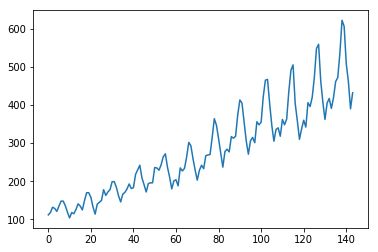

In [2]:
# fix random seed for reproducibility
numpy.random.seed(7)

#读取数据
dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

#查看数据集
print('样本中的前面两个数据: \n',dataset[0:2])
print('整个样本的规模: ',len(dataset))

plt.plot(dataset)
plt.show()

In [3]:
#LSTM对输入数据的规模很敏感，特别是在使用sigmoid（默认）或tanh激活函数时。
#将数据重新调整到0到1的范围（也称为标准化）可能是一种很好的做法。

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# 划分训练集与测试集
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print('划分数据集后的得到的训练数据和测试数据(训练数据未有标签): ',train.shape,test.shape)

划分数据集后的得到的训练数据和测试数据(训练数据未有标签):  (96, 1) (48, 1)


In [4]:
# 生成[t,t+look_back]时间间隔和t+look_back时刻的两个矩阵
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX[:2])
print(trainY[:2])

# 数据被Reshape成 [samples, time steps, features]，这是放入LSTM的shape
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX.shape,testX.shape)

[[0.01544401]
 [0.02702703]]
[0.02702703 0.05405405]
构造得到模型的输入数据(训练数据已有标签trainY):  (95, 1, 1) (47, 1, 1)


Epoch 1/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0405
Epoch 2/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0198
Epoch 3/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 4/50
95/95 [==============================] - 0s 989us/step - loss: 0.0130
Epoch 5/50
95/95 [==============================] - 0s 989us/step - loss: 0.0120
Epoch 6/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 7/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 8/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0090
Epoch 9/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0079
Epoch 10/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 11/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 12/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 13/50
95/95 [==========================

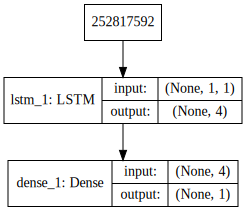

In [5]:
#构建LSTM网络
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

#编译训练LSTM网络
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

#打印模型
model.summary()

#保存模型
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

Train Score: 23.39 RMSE
Test Score: 46.92 RMSE


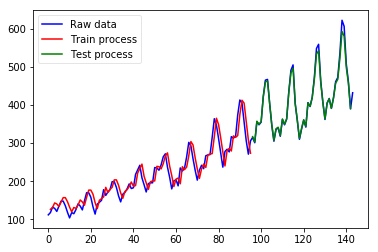

In [6]:
# 使用已训练的模型进行预测
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 预测的值是[0,1]这样的标准化数据，需要将该值转换回原始值
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


# 计算预测的均方根误差
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# 画图：对训练数据的预测
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


# 画图：对测试数据的预测
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
testPredictPlot[len(trainPredict)+look_back:len(dataset)-1, :] = testPredict

# 显示图片
plt.plot(scaler.inverse_transform(dataset),color='blue',label='Raw data')
plt.plot(trainPredictPlot,color='red',label='Train process')
plt.plot(testPredictPlot,color='green',label='Test process')

#在折线图上显示标签
leg = plt.legend(loc='best', ncol=1, fancybox=True)
leg.get_frame().set_alpha(0.5)

plt.show()

In [7]:
#测试数据的最后一个数据没有预测,这里补上
finalX = numpy.reshape(test[-1], (1, 1, testX.shape[1]))

#预测得到标准化数据
featruePredict = model.predict(finalX)

#将标准化数据转换为人数
featruePredict = scaler.inverse_transform(featruePredict)

#原始数据是1949-1960年的数据,下一个月是1961年1月份
print('模型预测1961年1月份的国际航班人数是: ',featruePredict)

模型预测1961年1月份的国际航班人数是:  [[430.2554]]
